# Evaluación de la segmentación

In [1]:
import cv2 as cv # ver. 4.5.5
import numpy as np
from matplotlib import pyplot as plt

## Imágenes a utilizar

En esta ocasión se usarán cartas de póquer para establecer la segmentación de objetos.

In [2]:
img_07c = cv.imread('im/07c.jpg', cv.IMREAD_GRAYSCALE)
img_09d = cv.imread('im/09d.png', cv.IMREAD_GRAYSCALE)
img_10c = cv.imread('im/10c.jpg', cv.IMREAD_GRAYSCALE)
img_10t = cv.imread('im/10t.jpg', cv.IMREAD_GRAYSCALE)
img_all = cv.imread('im/all.png', cv.IMREAD_GRAYSCALE)
img_4a6 = cv.imread('im/4a6.jpg', cv.IMREAD_GRAYSCALE)
#img_mis = cv.imread('im/unir-2.jpg', cv.IMREAD_GRAYSCALE)

## Segmentación ayudada con Canny

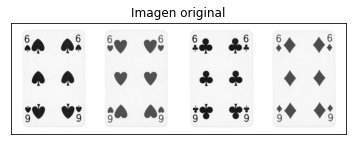

In [3]:
im = img_4a6
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
plt.imshow(im)
plt.title("Imagen original"), plt.xticks([]), plt.yticks([])
plt.show()

Una vez que seleccionamos una imagen en escala de grises, es posible obtener una imagen binaria con los bordes claramente identificados gracias al algoritmo de Canny.

In [4]:
# Los números son las intensidades min y máx para identificar el borde
canny = cv.Canny(im, 25, 100)
cv.imwrite('out/canny.jpg', canny)

True

Ver [Este enlace](https://circuitdigest.com/tutorial/image-segmentation-using-opencv) sobre segmentación y la documentación oficial de la [version 4.5.5 de opencv](https://docs.opencv.org/4.5.5/d4/d73/tutorial_py_contours_begin.html). El método `cv.findContours()` encuentra los contornos en una imagen binaria (primer parámetro). Debe especificarse el algoritmo que usará para encontrar los contornos (segundo parámetro):

- `RETR_EXTERNAL`: Detecta solo los bordes más externos.
- `RETR_LIST`: Detecta todos los contornos.
- `RETR_CCOMP` y `RETR_TREE`: Detectan todos los bordes y establecen alguna jerarquía entre ellos.

El último parámetro establece el método de aproximación para el contorno, los principales son:

- `CHAIN_APPROX_NONE`: Almacena absolutamente todos los puntos de contorno.
- `CHAIN_APPROX_SIMPLE`: Comprime segmentos horizontales, verticales y diagonales y deja sólo sus puntos finales.

Al cambiar este último parámetro no se han observado cambios en el resultado.

Por su parte el método `drawContours()` dibujará los contornos sobre la imagen original (primer parámetro); para ello debe acceder a los contornos previamente obtenidos (segundo parámetro). El tercer parámetro es aquel contorno específico a dibujar, `-1` significa todos. Los parámetros siguientes serán el color del contorno y su grosor.

In [5]:
contours, hierarchy = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
out = cv.drawContours(im, contours, -1, (64,255,64), 1)
cv.imwrite('out/out.jpg', out)
print('Número de contornos encontrados: ', len(contours))

Número de contornos encontrados:  4


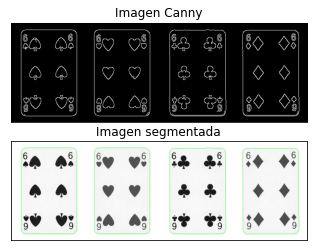

In [6]:
canny = cv.cvtColor(canny, cv.COLOR_BGR2RGB)
out = cv.cvtColor(out, cv.COLOR_BGR2RGB)
plt.subplot(211)
plt.imshow(canny)
plt.title('Imagen Canny'), plt.xticks([]), plt.yticks([])
plt.subplot(212)
plt.imshow(out)
plt.title('Imagen segmentada'), plt.xticks([]), plt.yticks([])
plt.show()

Como puede observarse en la imagen, los contornos son dibujados propiamente, sin embargo, el número de contornos puede no coincidir con el número de objetos en la imagen. Por ejemplo, los tréboles debido a lo angosto de la parte media del dibujo, pueden ser identificados como dos objetos y no como uno. A continuación se presenta una lista con la relación de objetos y contornos detectados:

<a id="tbl:1"></a>

| Carta | Objetos observables | Segmentos detectados
| :--- | :--- | :---
| 7 corazones | 11 | 11
| 9 diamantes | 13 | 14
| 10 corazones | 16 | 16
| 10 de tréboles | 16 | 18
| Deck | 52 | 56
| 4 cartas | 4 | 4

Es bien sabido que el algoritmo de Canny aplica una reducción de ruido con un filtro gausiano como primer paso. Parece ser que no es suficiente en todos los casos.

## Segmentación ayudada con umbralado

Es posible usar un umbralado directo para generar una imagen en binario. En este caso usaremos solo las imágenes que presentaron fallas en la sección anterior: `img_09d`, `img_10t` y `img_all`.

Este método mejora el resultado siempre y cuando la variable `thresh` tenga el valor ideal. Aquí se coloca el ejemplo que funciona con la carta nueve de diamantes donde `thresh = 32`, para corregir la imagen con toda la baraja de poquer es necesario establecer `thresh = 160`.

In [7]:
im = img_09d
# Imagen en binario
thresh = 32 #Los bits del umbralado
binary = cv.threshold(im, thresh, 255, cv.THRESH_BINARY)[1]

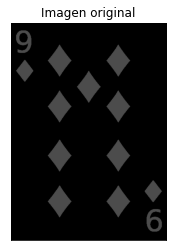

In [8]:
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
plt.imshow(im)
plt.title("Imagen original"), plt.xticks([]), plt.yticks([])
plt.show()

In [9]:
contours, hierarchy = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
out = cv.drawContours(im, contours, -1, (64,255,64), 3)
cv.imwrite('out/bin.jpg', binary)
cv.imwrite('out/bin_out.jpg', out)
print('Número de contornos encontrados: ', len(contours))

Número de contornos encontrados:  13


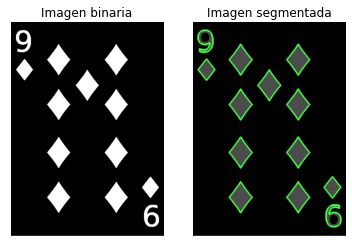

In [10]:
binary = cv.cvtColor(binary, cv.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(binary)
plt.title('Imagen binaria'), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(out)
plt.title('Imagen segmentada'), plt.xticks([]), plt.yticks([])
plt.show()

Es posible observar los siguientes resultados mediante este método:

| Carta | Objetos observables | Segmentos detectados (Umbral)
| :--- | :--- | :--- 
| 9 diamantes | 13 | 13 (32)
| 10 de tréboles | 16 | 1
| Deck | 52 | 52 (160)

## K-means

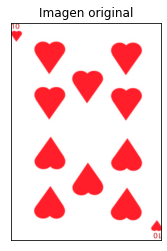

In [11]:
im = cv.imread('im/10c.jpg')
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
plt.imshow(im)
plt.title("Imagen original"), plt.xticks([]), plt.yticks([])
plt.show()

In [12]:
im = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)

NameError: name 'cv2' is not defined

In [ ]:
light_blue = (90, 70, 50)
dark_blue = (128, 255, 255)
# You can use the following values for green
# light_green = (40, 40, 40)
# dark_greek = (70, 255, 255)
mask = cv2.inRange(hsv_img, light_blue, dark_blue)

In [ ]:
result = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(result)
plt.title("Imagen original"), plt.xticks([]), plt.yticks([])
plt.show()

Por favor ver [Tabla 1](#tbl:1) y [Imágenes a utilizar](#Imágenes-a-utilizar)


\begin{align}
    g &= \int_a^b f(x)dx \label{eq1}\tag{1} \\
    a &= b + c \label{eq2}\tag{2}
\end{align}

See (\ref{eq1}) and (\ref{eq2})

See (\ref{eq1}) and (\ref{eq2}) does not work from another cell.
See ([1](#mjx-eqn-eq1)) and ([2](#mjx-eqn-eq2)) does work from another cell.